### Pre-Processing (Dataset and Setup)

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
df = pd.read_csv('/content/Mall_Customers.xls')

In [3]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
df.isnull().sum()

,0
CustomerID,0
Gender,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


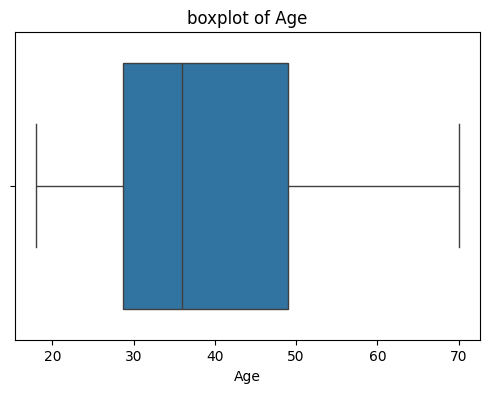

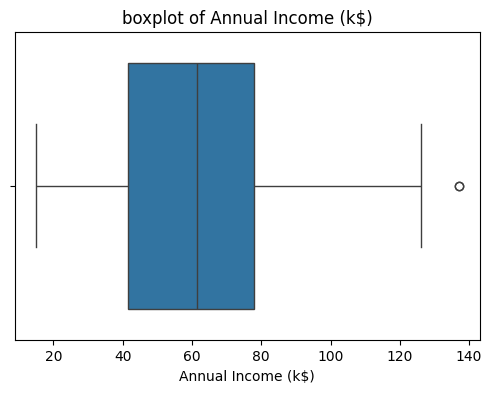

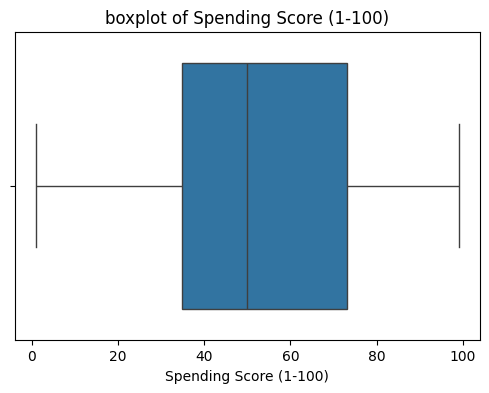

In [13]:
numeric_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

for col in numeric_cols:
  plt.figure(figsize=(6, 4))
  sns.boxplot(x=df[col])
  plt.title(f'boxplot of {col}')
  plt.show()


In [18]:
## encoding the features
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,1,19,15,39
1,2,1,21,15,81
2,3,0,20,16,6
3,4,0,23,16,77
4,5,0,31,17,40


In [21]:
## normalising the features
from sklearn.preprocessing import MinMaxScaler

customer_ids = df['CustomerID']

features = df.drop('CustomerID', axis=1)

scaler = MinMaxScaler()
features_scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)

df_scaled = pd.concat([customer_ids, features_scaled], axis=1)

In [22]:
df_scaled.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,1.0,0.019231,0.000000,0.387755
1,2,1.0,0.057692,0.000000,0.816327
2,3,0.0,0.038462,0.008197,0.051020
3,4,0.0,0.096154,0.008197,0.775510
4,5,0.0,0.250000,0.016393,0.397959


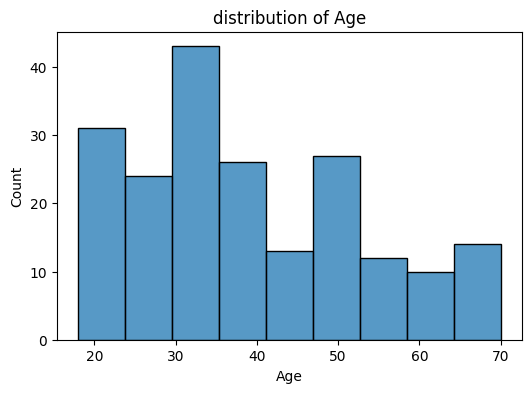

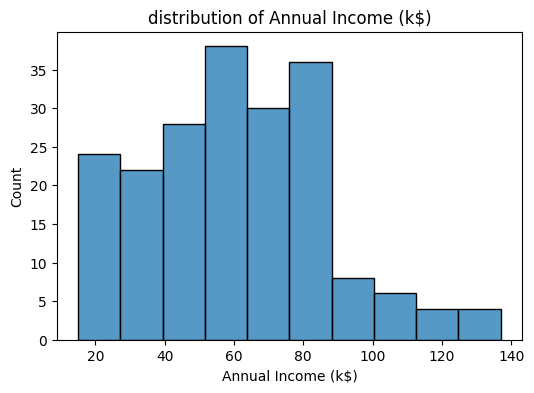

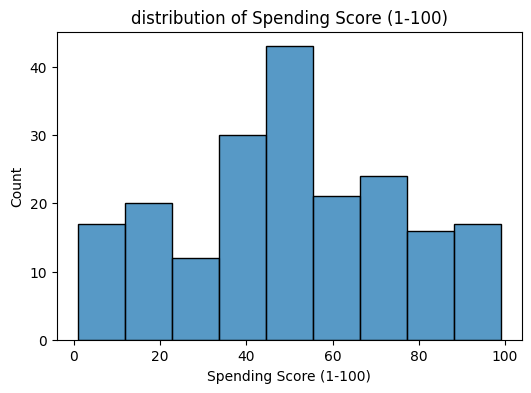

In [24]:
cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

for col in numeric_cols:
  plt.figure(figsize=(6, 4))
  sns.histplot(x=df[col])
  plt.title(f'distribution of {col}')
  plt.show()


## Implementing K-means from scratch

In [25]:
## initialisation

def initialize_centroids(X, k, random_state=None):
  if random_state is not None:
    np.random.seed(random_state)

  n_samples = X.shape[0]
  random_indices = np.random.choice(n_samples, size =k, replace=False)

  centroids = X[random_indices]

  return centroids

In [26]:
def initialise_centroids_kmeanspp(X, k, random_state=None):
  if random_state is not None:
    np.random.seed(random_state)

  n_samples, n_features = X.shape

  first_centroid_idx = np.random.randint(n_samples)
  centroids = X[first_centroid_idx]

  for _ in range (1, k):
    distances = np.array([
        min(np.linalg.norm(x -c)**2 for c in centroids) for x in X
    ])

    probabilities = distances/ distances.sum()

    next_centroid_idx = np.random.choice(n_samples, p=probabilities)
    centroids.append(X[next_centroid_idx])

  return np.array(centroids)


In [27]:
## assignment

def assign_clusters(X, centroids):
  labels = []

  for x in X:
    distances = []

    for c in centroids:
      distance = np.linalg.norm(x - c)
      distances.append(distance)

    label = np.argmin(distances)
    labels.append(label)

  return np.array(labels)

In [28]:
def update_centroids(X, labels, k):
  new_centroids = []

  for i in range(k):
    points_in_cluster = X[labels == i]

    if len(points_in_cluster) > 0 :
      new_centroid = points_in_cluster.mean(axis=0)
      new_centroids.append(new_centroid)
    else:
      new_centroid = np.zeros(X.shape[1])
      new_centroids.append(new_centroid)

  return np.array(new_centroids)

In [29]:
## main algorithm loop

def kmeans(X, k, max_iters=100, tol=1e-4, random_state=None):
  if random_state is not None:
    np.random.seed(random_state)

  n_samples, n_features = X.shape
  centroids = initialize_centroids(X, k, random_state)

  for i in range(max_iters):
      labels = assign_clusters(X, centroids)

      new_centroids = update_centroids(X, labels, k)

      shift = np.linalg.norm(new_centroids - centroids)

      if shift < tol:
          break

      centroids = new_centroids


  distances = []
  for idx, x in enumerate(X):
      c = centroids[labels[idx]]
      distances.append(np.linalg.norm(x - c) ** 2)
  inertia = np.sum(distances)

  return centroids, labels, i + 1, inertia

In [30]:
## elbow method and silhouette score
## just importing silhouetter score from sklearn
from sklearn.metrics import silhouette_score

def evaluate_k_range(X, k_min=2, k_max = 10, random_state=None):
  intertias = []
  silhouettes = []

  for k in range(k_min, k_max+1):
    centroids, labels, iter, inertia = kmeans(X, k, random_state=random_state)
    intertias.append(inertia)

    if len(set(labels)) > 1:
      sil = silhouette_score(X, labels)
    else:
      sil = np.nan
    silhouettes.append(sil)

    print(f"k={k}: inertia={inertia:.3f}, silhouetter={sil:.3f}")


  results = pd.DataFrame({
      "k": range(k_min, k_max+1),
      "inertia": intertias,
      "silhouette": silhouettes
  })

  fig, ax1 = plt.subplots(figsize=(8,5))

  color = 'tab:blue'
  ax1.set_xlabel("Number of Clusters (k)")
  ax1.set_ylabel("Inertia", color=color)
  ax1.plot(results["k"], results["inertia"], marker='o', color=color)
  ax1.tick_params(axis='y', labelcolor=color)
  ax1.set_title("Elbow Method and Silhouette Score")

  ax2 = ax1.twinx()
  color = 'tab:orange'
  ax2.set_ylabel("Silhouette Score", color=color)
  ax2.plot(results["k"], results["silhouette"], marker='s', linestyle='--', color=color)
  ax2.tick_params(axis='y', labelcolor=color)

  plt.show()

  return results

k=2: inertia=166780.410, silhouetter=0.623
k=3: inertia=74213.691, silhouetter=0.583
k=4: inertia=41852.567, silhouetter=0.562
k=5: inertia=27126.958, silhouetter=0.548
k=6: inertia=18740.319, silhouetter=0.538
k=7: inertia=13961.804, silhouetter=0.529
k=8: inertia=10550.109, silhouetter=0.524
k=9: inertia=8642.428, silhouetter=0.516
k=10: inertia=6775.452, silhouetter=0.510


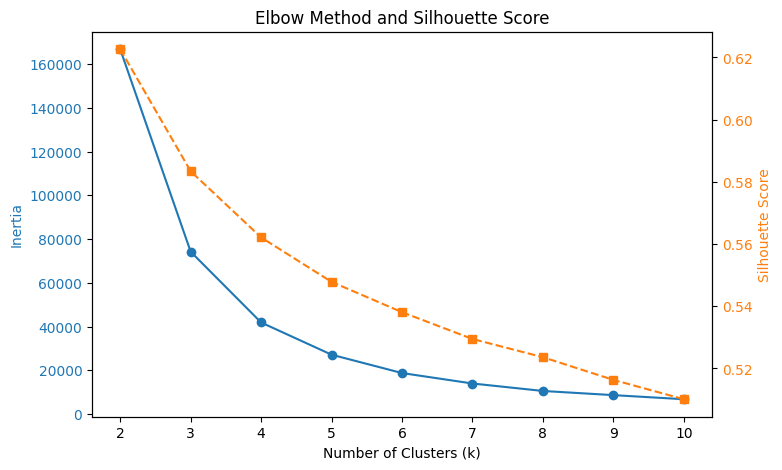

    k        inertia  silhouette
0   2  166780.410051    0.622640
1   3   74213.691158    0.583402
2   4   41852.567134    0.562121
3   5   27126.957987    0.547831
4   6   18740.318571    0.538084
5   7   13961.804301    0.529464
6   8   10550.109159    0.523606
7   9    8642.427680    0.516314
8  10    6775.451654    0.510099


In [32]:
## applying the algorithmm
X = df_scaled.values
results = evaluate_k_range(X, k_min=2, k_max=10, random_state=42)

print(results)


In [33]:
chosen_k = 4

centroids, labels, n_iter, inertia = kmeans(X, k=chosen_k,max_iters=100, tol=0.0001, random_state=42)

print("Final centroids:\n", centroids)
print("Inertia:", inertia)
print("Iterations:", n_iter)

Final centroids:
 [[1.23000000e+02 4.90196078e-01 3.91402715e-01 4.37319190e-01
  5.05602241e-01]
 [2.45000000e+01 3.75000000e-01 3.36538462e-01 9.73360656e-02
  4.97874150e-01]
 [7.30000000e+01 4.28571429e-01 5.07849294e-01 2.92572767e-01
  5.02498959e-01]
 [1.74500000e+02 4.61538462e-01 3.69082840e-01 6.41866330e-01
  5.01962323e-01]]
Inertia: 41852.56713416714
Iterations: 18


In [34]:
df_scaled["cluster"] = labels

In [36]:
cluster_means = df_scaled.groupby("cluster").mean()
print(cluster_means)


         CustomerID    Gender       Age  Annual Income (k$)  \
cluster                                                       
0             123.0  0.490196  0.391403            0.437319   
1              24.5  0.375000  0.336538            0.097336   
2              73.0  0.428571  0.507849            0.292573   
3             174.5  0.461538  0.369083            0.641866   

         Spending Score (1-100)  
cluster                          
0                      0.505602  
1                      0.497874  
2                      0.502499  
3                      0.501962  


Cluster 0: Average-age, middle-income customers with moderate spending behavior.

Cluster 1: Younger, low-income customers who spend moderately

Cluster 2: Older, mid-income customers who spend consistently

Cluster 3: Younger, high-income customers with average spending levels

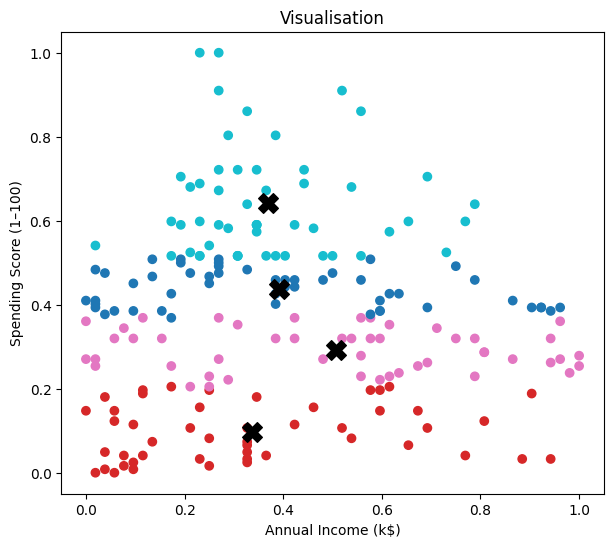

In [38]:
plt.figure(figsize=(7,6))
plt.scatter(df_scaled.iloc[:, 2], df_scaled.iloc[:, 3], c=labels, cmap='tab10')
plt.scatter(centroids[:, 2], centroids[:, 3], c='black', marker='X', s=200)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1–100)')
plt.title('Visualisation')
plt.show()


In [40]:
from sklearn.cluster import KMeans


# Run sklearn KMeans
sk_kmeans = KMeans(
    n_clusters=chosen_k,
    max_iter=100,
    tol=1e-4,
    random_state=42
)

sk_kmeans.fit(X)

sk_centroids = sk_kmeans.cluster_centers_
sk_inertia = sk_kmeans.inertia_
sk_iters = sk_kmeans.n_iter_

print("scikit-learn KMeans Results:")
print(f"Final Inertia: {sk_inertia:.4f}")
print(f"Iterations until convergence: {sk_iters}")
print(f"Centroids:\n{sk_centroids}")


scikit-learn KMeans Results:
Final Inertia: 41752.4717
Iterations until convergence: 6
Centroids:
[[7.45000000e+01 4.40000000e-01 5.08461538e-01 2.97540984e-01
  5.02448980e-01]
 [1.75500000e+02 4.60000000e-01 3.71538462e-01 6.46885246e-01
  4.99591837e-01]
 [2.50000000e+01 3.67346939e-01 3.33987441e-01 9.95316159e-02
  4.96251562e-01]
 [1.25000000e+02 4.90196078e-01 3.88763198e-01 4.42944391e-01
  5.09603842e-01]]


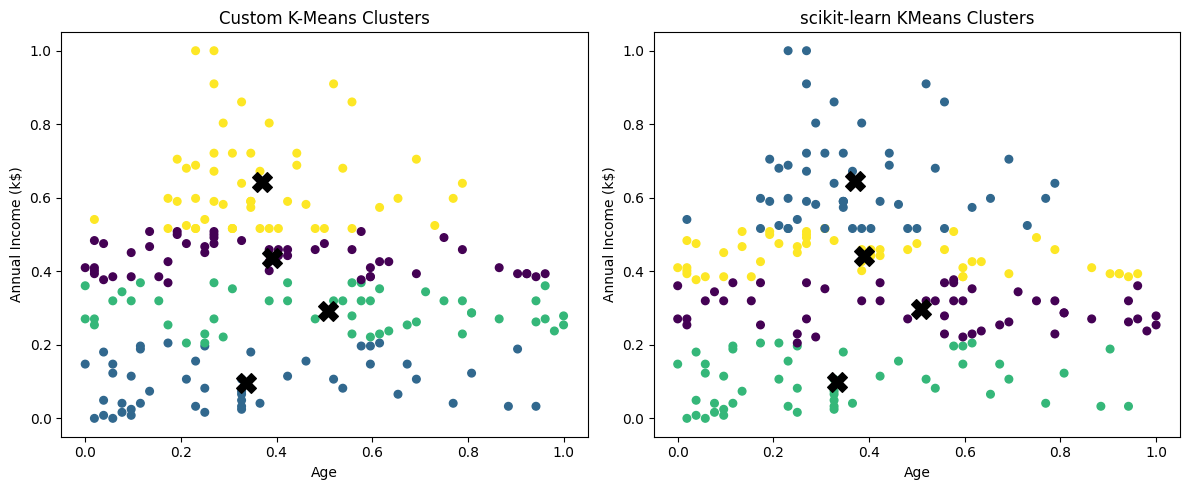

In [43]:

centroids_custom, labels_custom, n_iter_custom, inertia_custom = kmeans(
    X, k=chosen_k, max_iters=100, tol=1e-4, random_state=42
)

sk_kmeans = KMeans(n_clusters=chosen_k, max_iter=100, tol=1e-4, random_state=42)
sk_kmeans.fit(X)
labels_sk = sk_kmeans.labels_
centroids_sk = sk_kmeans.cluster_centers_

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

x_idx, y_idx = 2, 3

# Custom K-Means plot
axes[0].scatter(X[:, x_idx], X[:, y_idx], c=labels_custom, cmap='viridis', s=30)
axes[0].scatter(centroids_custom[:, x_idx], centroids_custom[:, y_idx], c='black', marker='X', s=200)
axes[0].set_title("Custom K-Means Clusters")
axes[0].set_xlabel(df_scaled.columns[x_idx])
axes[0].set_ylabel(df_scaled.columns[y_idx])

# scikit-learn K-Means plot
axes[1].scatter(X[:, x_idx], X[:, y_idx], c=labels_sk, cmap='viridis', s=30)
axes[1].scatter(centroids_sk[:, x_idx], centroids_sk[:, y_idx], c='black', marker='X', s=200)
axes[1].set_title("scikit-learn KMeans Clusters")
axes[1].set_xlabel(df_scaled.columns[x_idx])
axes[1].set_ylabel(df_scaled.columns[y_idx])

plt.tight_layout()
plt.show()